## Installations and importations

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
%matplotlib ipympl
from ipynb.fs.full.triangle_matching import triangle_matching_fn

### Load images

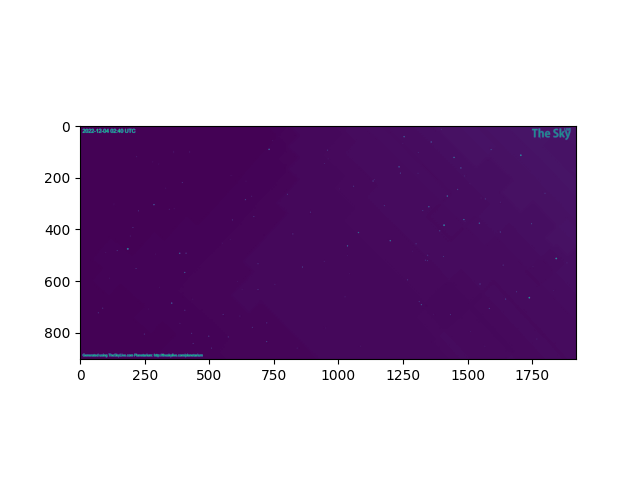

In [109]:
Image_Src_dir = 'SkyLive_8_320_images'
Image_files = os.listdir(Image_Src_dir)

IMAGES = []
for file in Image_files:
    IMAGES.append(cv2.imread(Image_Src_dir+"\\"+file))    
    IMAGES[-1] = cv2.cvtColor(IMAGES[-1], cv2.COLOR_BGR2GRAY)
    IMAGES[-1] = np.array(IMAGES[-1], dtype=np.float_)/255

# Plot(1st image)
plt.figure(1)
plt.imshow(IMAGES[0])
plt.show()

### Crop images if neccessary

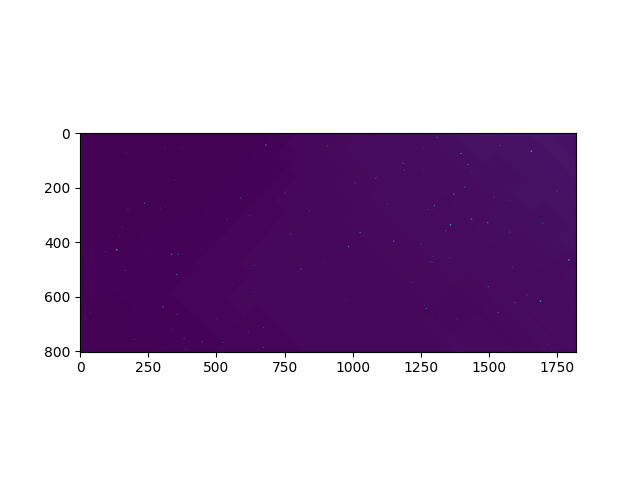

In [110]:
Crop_border = 50
for image_no in range(len(IMAGES)):
    IMAGES[image_no] = IMAGES[image_no][Crop_border:IMAGES[image_no].shape[0]-Crop_border, Crop_border:IMAGES[image_no].shape[1]-Crop_border]

plt.figure(2)
plt.imshow(IMAGES[0])
plt.show()

### Threshold

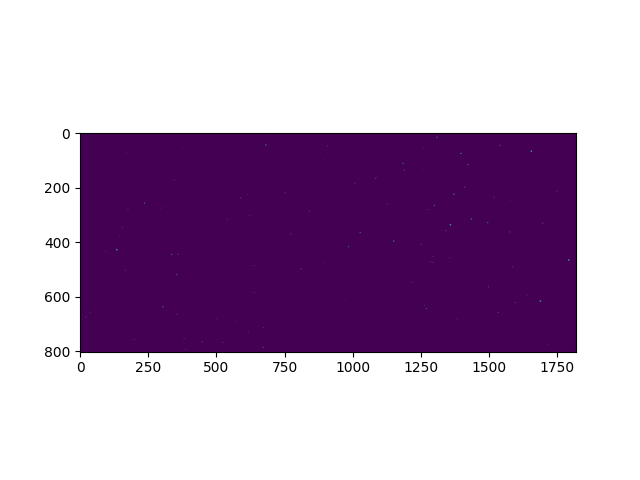

In [111]:
Threshold = 0.4
for image_no in range(len(IMAGES)):
    IMAGES[image_no][IMAGES[image_no] < Threshold] = 0
    #IMAGES[image_no][IMAGES[image_no] >= Threshold] = 1

plt.figure(3)
plt.imshow(IMAGES[0])
plt.show()

### Identify star locations

In [112]:
STARS = [] #Store size and location of all stars

for image_no in range(len(IMAGES)):
    print("Locating stars in Image-",image_no)
    image_copy = np.copy(IMAGES[image_no])

    Star_indices = np.argwhere(image_copy)
    stars = []
    while(Star_indices.shape[0] != 0):
        Rand_pos = Star_indices[random.randrange(Star_indices.shape[0])]

        Up_shift = 0
        Right_shift = 0
        Down_shift = 0
        Left_shift = 0
        #Rand_pos = np.array([615, 1689], dtype=np.int_)        
        while True:
            if(Rand_pos[0]-Up_shift != 0):
                if(np.any(image_copy[Rand_pos[0]-Up_shift, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])):
                    Up_shift = Up_shift+1
                    continue
            if(Rand_pos[1]+Right_shift != image_copy.shape[1]-1):
                if(np.any(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]+Right_shift])):
                    Right_shift = Right_shift+1
                    continue
            if(Rand_pos[0]+Down_shift != image_copy.shape[0]-1):
                if(np.any(image_copy[Rand_pos[0]+Down_shift, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])):
                    Down_shift = Down_shift+1
                    continue
            if(Rand_pos[1]-Left_shift != 0):
                if(np.any(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift])):
                    Left_shift = Left_shift+1
                    continue
            break

        #Find star size
        star_size = np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1])

        #Find star row
        star_row = np.dot(np.array(range(Rand_pos[0]-Up_shift, Rand_pos[0]+Down_shift+1)), np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1], axis=1))/star_size

        #Find star column    
        star_col = np.dot(np.array(range(Rand_pos[1]-Left_shift, Rand_pos[1]+Right_shift+1)), np.sum(image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1], axis=0))/star_size    

        #Add star to list
        stars.append(np.array([star_size, star_row, star_col]))

        #Remove found star
        image_copy[Rand_pos[0]-Up_shift:Rand_pos[0]+Down_shift+1, Rand_pos[1]-Left_shift:Rand_pos[1]+Right_shift+1] = 0

        #New star indices
        Star_indices = np.argwhere(image_copy)
                
    #The array of all stars
    STARS.append(np.array(stars))

Locating stars in Image- 0
Locating stars in Image- 1
Locating stars in Image- 2
Locating stars in Image- 3
Locating stars in Image- 4


### Plot located stars (only image-1)

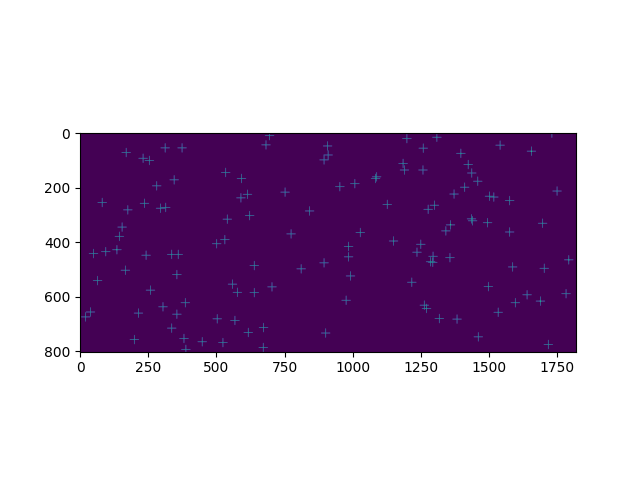

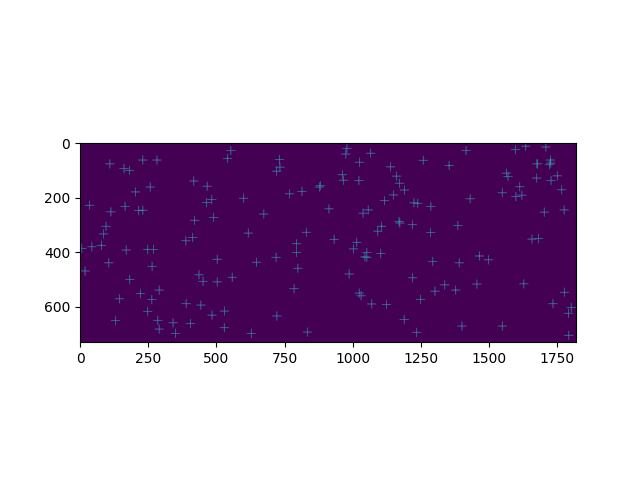

In [113]:
Plot_length = 16
image_copy = IMAGES[0].copy()
for star in STARS[0]:
    image_copy[max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[0]]),  round(star[2])] = 1
    image_copy[round(star[1]), max([round(star[2])-Plot_length, 0]) : min([round(star[2])+Plot_length+1, image_copy.shape[1]])] = 1
plt.figure(4)
plt.imshow(image_copy)
plt.show()

image_copy = IMAGES[1].copy()
for star in STARS[1]:
    image_copy[max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[0]]),  round(star[2])] = 1
    image_copy[round(star[1]), max([round(star[2])-Plot_length, 0]) : min([round(star[2])+Plot_length+1, image_copy.shape[1]])] = 1
plt.figure(100)
plt.imshow(image_copy)
plt.show()

### Sorting the stars based on size

In [114]:
for image_no in range(len(STARS)):
    STARS[image_no] = STARS[image_no][np.argsort(STARS[image_no][:,0])[::-1],:]

### Forming the triangles

In [115]:
Num_stars = 30

def Compute_dist(point1, point2):
    return np.sqrt( (point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 )

TRIANGLES = []
TRIANGLE_VERTICES = []
for image_no in range(len(IMAGES)):
    stars_copy = STARS[image_no][:min([Num_stars, STARS[image_no].shape[0]]),:]
    triangles = []
    triangle_vertices = []

    Triangle_vertex_indices = np.array([0,1,2], dtype=np.int_)
    while(Triangle_vertex_indices[0]<stars_copy.shape[0]):
        Triangle_vertex_indices[1] = Triangle_vertex_indices[0]+1
        while(Triangle_vertex_indices[1]<stars_copy.shape[0]):
            Triangle_vertex_indices[2] = Triangle_vertex_indices[1]+1
            while(Triangle_vertex_indices[2]<stars_copy.shape[0]):
                


                # List of stars
                star_array = np.array([stars_copy[Triangle_vertex_indices[0],1:], stars_copy[Triangle_vertex_indices[1],1:], stars_copy[Triangle_vertex_indices[2],1:]])
                
                # Compute array of sides
                Side1 = Compute_dist(star_array[0], star_array[1])
                Side2 = Compute_dist(star_array[1], star_array[2])
                Side3 = Compute_dist(star_array[2], star_array[0])    
                Side_array = np.array([Side1, Side2, Side3])


                # Sort stars based on side order
                """
                SIDE order to STAR order
                0 1 2 --- 0 1 2
                1 0 2 --- 2 1 0
                1 2 0 --- 1 2 0
                2 1 0 --- 0 2 1
                2 0 1 --- 2 0 1
                0 2 1 --- 1 0 2
                """
                Star_sort_indices = np.argsort(Side_array)
                if( ((Star_sort_indices[1] - Star_sort_indices[0]) == -1) or ((Star_sort_indices[2] - Star_sort_indices[1]) == -1) ):
                    Star_sort_indices = np.mod(Star_sort_indices+1,3)

                # Append
                triangle_vertices.append(star_array[Star_sort_indices])
                triangles.append(np.sort(Side_array))


                Triangle_vertex_indices[2] += 1
            Triangle_vertex_indices[1] += 1
        Triangle_vertex_indices[0] += 1
    TRIANGLES.append(np.array(triangles))
    TRIANGLE_VERTICES.append(triangle_vertices)

### Triangle matching

In [116]:
SIMILARITY_MAP = triangle_matching_fn(TRIANGLES,one_to_one=False)

### Computing AFFINEs of all matched  triangles
### Then taking mode

In [142]:
Mode_bins = 10000

def compute_AFFINE(Points1, Points2):
    Mat = np.linalg.inv(np.concatenate((Points1, np.array([[1],[1],[1]])), axis=1))
    return np.reshape(Mat @ Points2, (6))

TRANSFORMS = []
for image_no in range(len(IMAGES)):
    transforms = []
    Mode = []
    
    for index in range(SIMILARITY_MAP[image_no].shape[0]):
        transforms.append(cv2.getAffineTransform(np.float32(TRIANGLE_VERTICES[image_no][index]), np.float32(TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[image_no][index])])).reshape((6)))
        #transforms.append(compute_AFFINE(TRIANGLE_VERTICES[image_no][index], TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[image_no][index])]))
    transforms = np.array(transforms)

    for index in range(6):
        dist = transforms[:,index]
        freq, bins = np.histogram(dist[np.abs(dist)<2000], bins=Mode_bins)
        Mode.append( (bins[np.argmax(freq)] + bins[np.argmax(freq)+1])/2 )
    TRANSFORMS.append(np.array(Mode))

In [143]:
OUTPUT_IMAGES = []
for index in range(len(IMAGES)):
    OUTPUT_IMAGES.append(cv2.warpAffine(IMAGES[index], TRANSFORMS[index].reshape((2,3)), (IMAGES[0].shape[::-1])))

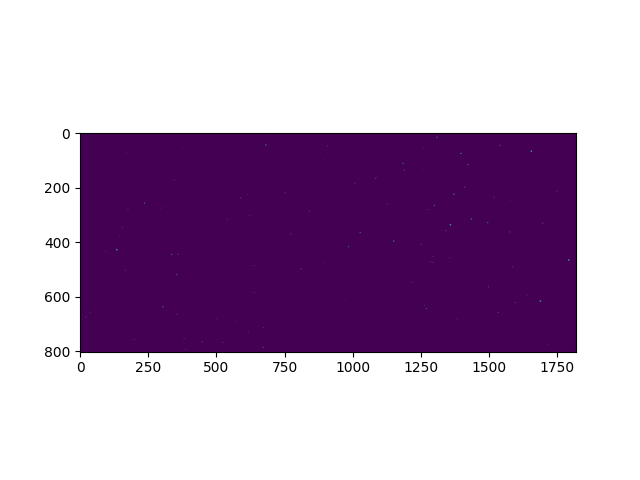

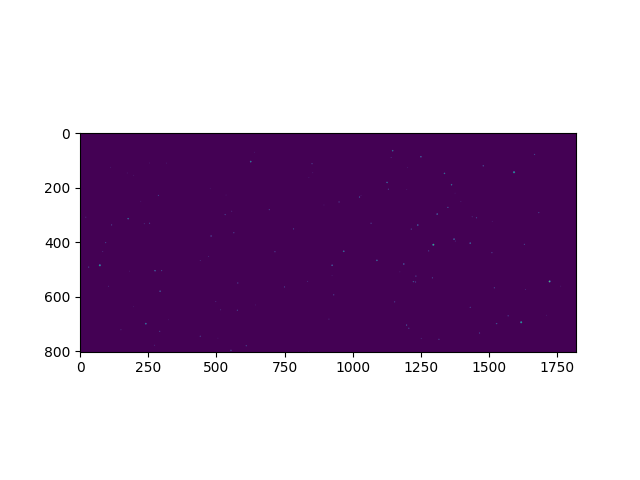

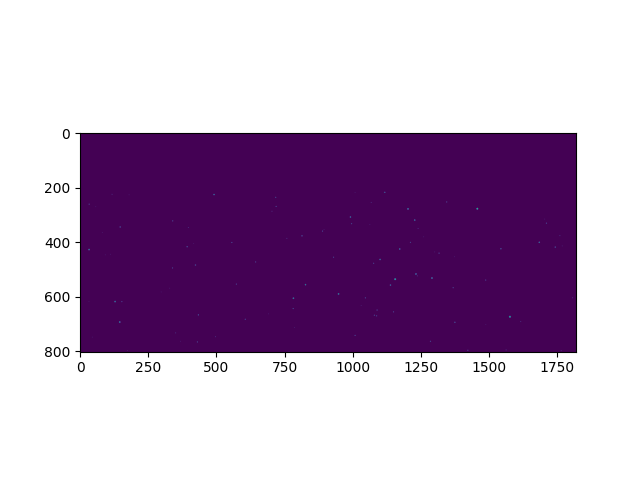

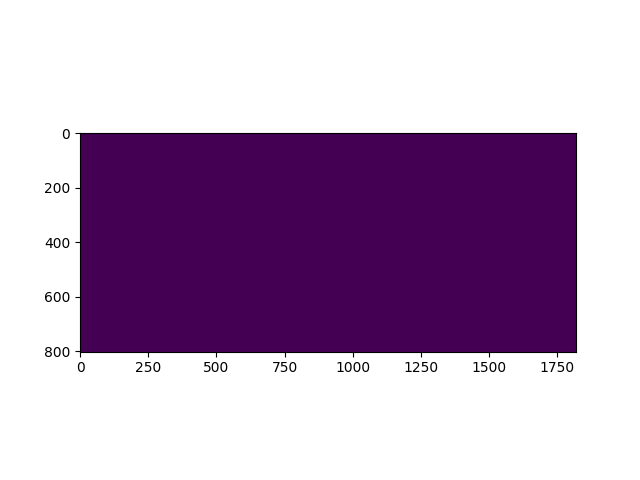

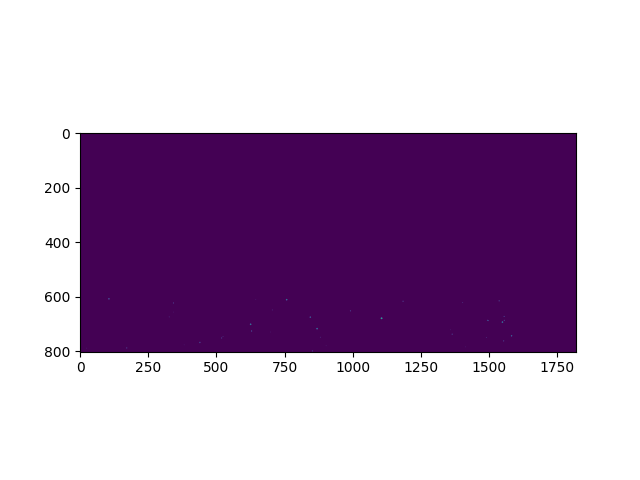

In [144]:
plt.figure(5)
plt.imshow(OUTPUT_IMAGES[0])
plt.show()

plt.figure(6)
plt.imshow(OUTPUT_IMAGES[1])
plt.show()

plt.figure(7)
plt.imshow(OUTPUT_IMAGES[2])
plt.show()

plt.figure(8)
plt.imshow(OUTPUT_IMAGES[3])
plt.show()

plt.figure(9)
plt.imshow(OUTPUT_IMAGES[4])
plt.show()


In [145]:
TRANSFORMS

[array([ 1.00000000e+00, -6.75961344e-19, -1.29435463e-14,  7.31994662e-18,
         1.00000000e+00,  4.30309709e-15]),
 array([ 1.19011808e+00, -5.80862226e-03, -1.82324292e+01,  8.71054606e-03,
         1.20223686e+00,  3.28161387e+01]),
 array([ 1.18905055e+00, -2.82318544e-02,  2.55629611e+01,  1.64075201e-02,
         1.18793544e+00,  2.01196887e+02]),
 array([ 2.16946518e-01, -1.97468304e-01,  1.53867553e+02, -2.86312266e-02,
        -2.60712866e-01, -1.06973603e+02]),
 array([ 1.11488152e+00, -3.40095479e-02,  1.29009750e+01,  2.32824089e-02,
         1.09179445e+00,  5.81766612e+02])]

In [121]:
TRANSFORMS

[array([ 1.00000000e+00, -6.75961344e-19, -1.29435463e-14,  7.31994662e-18,
         1.00000000e+00,  4.30309709e-15]),
 array([ 1.19011808e+00, -5.80862226e-03, -2.27695320e+01,  8.71054606e-03,
         1.20223686e+00,  3.31484683e+01]),
 array([ 1.18905055e+00, -2.82318544e-02, -3.27880205e+00,  1.64075201e-02,
         1.18793544e+00,  2.28512917e+02]),
 array([ 2.16946518e-01, -1.97468304e-01,  4.67175790e+02, -2.86312266e-02,
        -2.60712866e-01,  1.76871987e+03]),
 array([ 1.11488152e+00, -3.40095479e-02,  8.51126957e+00,  2.32824089e-02,
         1.09179445e+00,  5.77423877e+02])]

In [122]:
TRANSFORMS

[array([ 1.00000000e+00, -6.75961344e-19, -1.29435463e-14,  7.31994662e-18,
         1.00000000e+00,  4.30309709e-15]),
 array([ 1.19011808e+00, -5.80862226e-03, -2.27695320e+01,  8.71054606e-03,
         1.20223686e+00,  3.31484683e+01]),
 array([ 1.18905055e+00, -2.82318544e-02, -3.27880205e+00,  1.64075201e-02,
         1.18793544e+00,  2.28512917e+02]),
 array([ 2.16946518e-01, -1.97468304e-01,  4.67175790e+02, -2.86312266e-02,
        -2.60712866e-01,  1.76871987e+03]),
 array([ 1.11488152e+00, -3.40095479e-02,  8.51126957e+00,  2.32824089e-02,
         1.09179445e+00,  5.77423877e+02])]

In [123]:
TRANSFORMS[0].reshape((2,3))

array([[ 1.00000000e+00, -6.75961344e-19, -1.29435463e-14],
       [ 7.31994662e-18,  1.00000000e+00,  4.30309709e-15]])

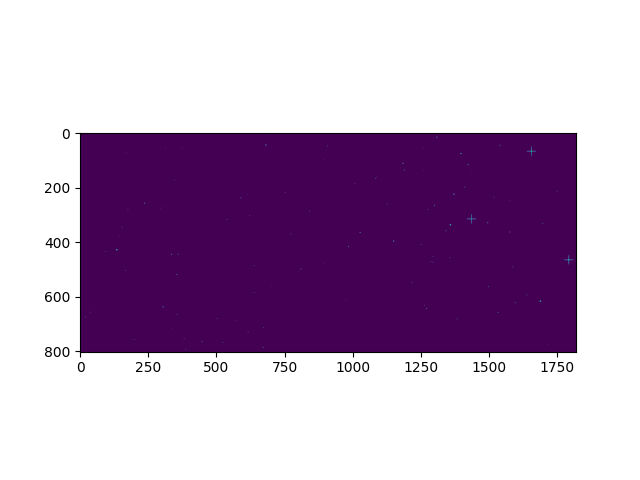

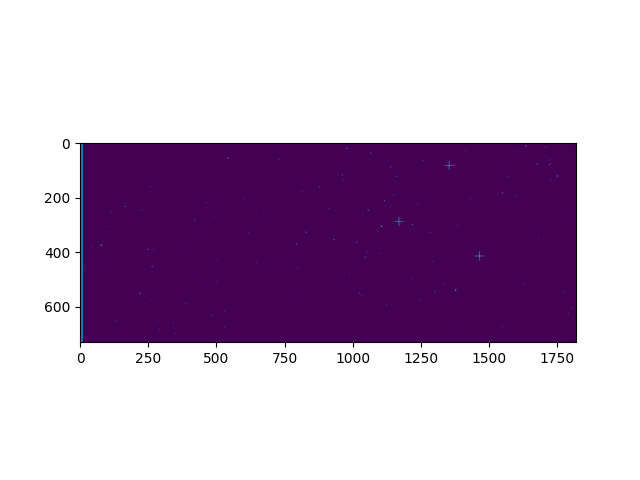

[ 5.96427384e-01 -1.30740657e-01  1.54585753e+02 -1.34324614e-01
 -6.00634406e-01  2.25504297e+03]


In [124]:
i=8

Plot_length = 16
image_copy = IMAGES[0].copy()
for star in TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[1][i])]:
    image_copy[max([round(star[0])-Plot_length, 0]) : min([round(star[0])+Plot_length+1, image_copy.shape[0]]),  round(star[1])] = 1
    image_copy[round(star[0]), max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[1]])] = 1
plt.figure(11)
plt.imshow(image_copy)
plt.show()

Plot_length = 16
image_copy = IMAGES[1].copy()
for star in TRIANGLE_VERTICES[1][i]:
    image_copy[max([round(star[0])-Plot_length, 0]) : min([round(star[0])+Plot_length+1, image_copy.shape[0]]),  round(star[1])] = 1
    image_copy[round(star[0]), max([round(star[1])-Plot_length, 0]) : min([round(star[1])+Plot_length+1, image_copy.shape[1]])] = 1
plt.figure(12)
plt.imshow(image_copy)
plt.show()


print(transforms[i])

In [125]:
transforms

array([[ 1.09790484e+00, -1.93674500e-02,  1.14753000e+01,
         2.07855963e-02,  1.11403622e+00,  5.59816529e+02],
       [ 1.09802559e+00, -2.23551390e-02,  1.44028500e+01,
         2.12636414e-02,  1.10220815e+00,  5.71406516e+02],
       [ 6.38254701e-01,  3.50500884e-01, -5.72553107e+01,
        -3.52576659e-01,  6.40897367e-01,  1.09141677e+03],
       ...,
       [ 8.44410424e-01,  2.60247899e-01, -4.51419977e+02,
        -2.39709469e-01,  8.49741311e-01, -2.58672770e+02],
       [-9.45126332e-01,  1.18252966e+00, -1.27196798e+03,
        -1.16877099e+00, -9.89877483e-01,  3.40505066e+03],
       [-2.65830697e-01, -9.81506566e-01,  1.98840760e+03,
        -9.81573254e-01,  2.79089261e-01,  1.36957733e+03]])

In [126]:
for star in TRIANGLE_VERTICES[0][int(SIMILARITY_MAP[1][i])]:
    print(star[0])

66.17508315693982
314.10914051841746
464.2485750474985


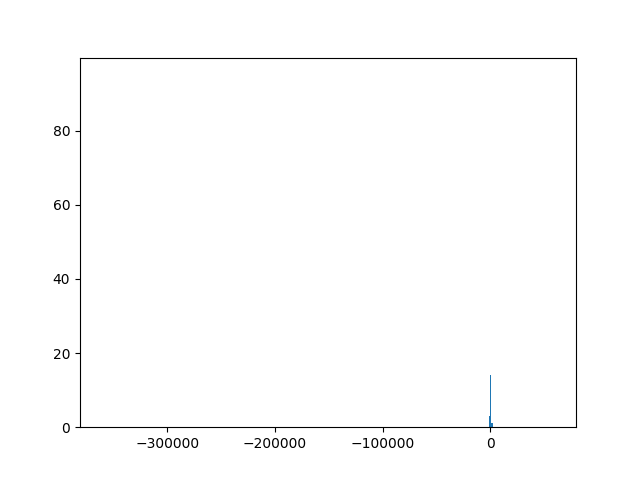

In [141]:
plt.figure(53)
plt.clf()
plt.hist(transforms[:,2], bins=100000)
plt.show()

In [134]:
print(TRANSFORMS)

[array([ 1.00000000e+00, -6.75961344e-19, -1.29435463e-14,  7.31994662e-18,
        1.00000000e+00,  4.30309709e-15]), array([ 1.19011808e+00, -5.80862226e-03, -2.27695320e+01,  8.71054606e-03,
        1.20223686e+00,  3.31484683e+01]), array([ 1.18905055e+00, -2.82318544e-02, -3.27880205e+00,  1.64075201e-02,
        1.18793544e+00,  2.28512917e+02]), array([ 2.16946518e-01, -1.97468304e-01,  4.67175790e+02, -2.86312266e-02,
       -2.60712866e-01,  1.76871987e+03]), array([ 1.11488152e+00, -3.40095479e-02,  8.51126957e+00,  2.32824089e-02,
        1.09179445e+00,  5.77423877e+02])]
